1/9 — 37.95 seconds left
2/9 — 34.17 seconds left
3/9 — 28.17 seconds left
4/9 — 23.72 seconds left
5/9 — 19.4 seconds left
6/9 — 14.33 seconds left
7/9 — 10.58 seconds left
8/9 — 4.68 seconds left
9/9 — 0.0 seconds left


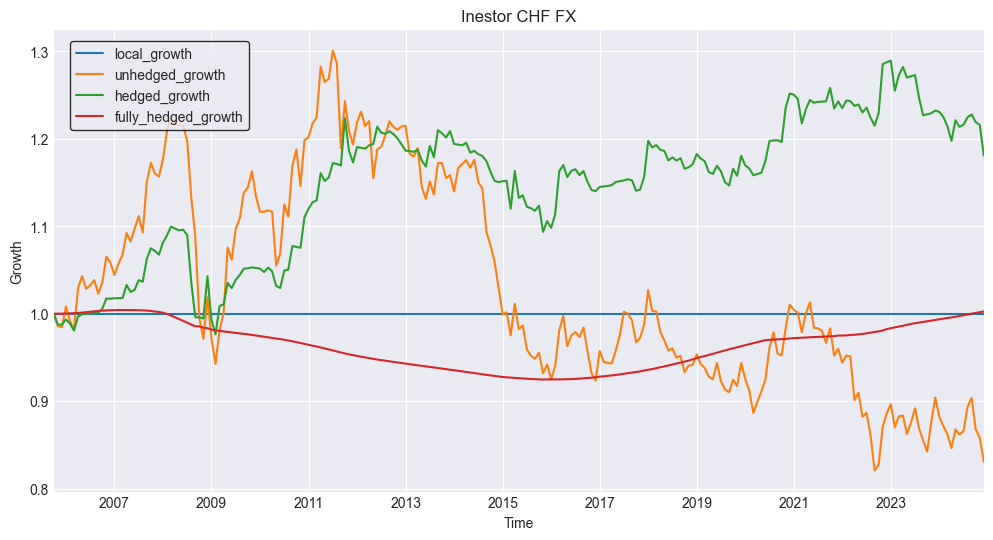

In [2]:
from database.insert import *
from database.models import *
from database.functions import *
from database.session import session
from simulation.functions import *
import pandas as pd
import numpy as np


base = 'USD'
portfolio_name = 'portfolio' + base



title = 'US FX'
data = get_portfolio_data(portfolio_name,base)


asset_logreturns = data[0]
currency_list = data[1]
fx_logreturns = data[2]
fwd_logreturns = data[3]
weights = data[4]
df_hedge = data[5]
factors = data[6]

predict = xgboost(currency_list,
                  df_hedge,
                  factors,
                  duration =2)

hedge_ratios = predict[0]

df = simulate_portfolio(asset_logreturns,
                        currency_list,
                        fx_logreturns,
                        fwd_logreturns,
                        weights,
                        hedge_ratios,
                        start = '2005-10-31',
                        end = '2024-12-31',
                        fx_portfolio = True)

plot_simulation(df,title,save = True)


factors = predict[2]
hedge_logreturns = predict[3]



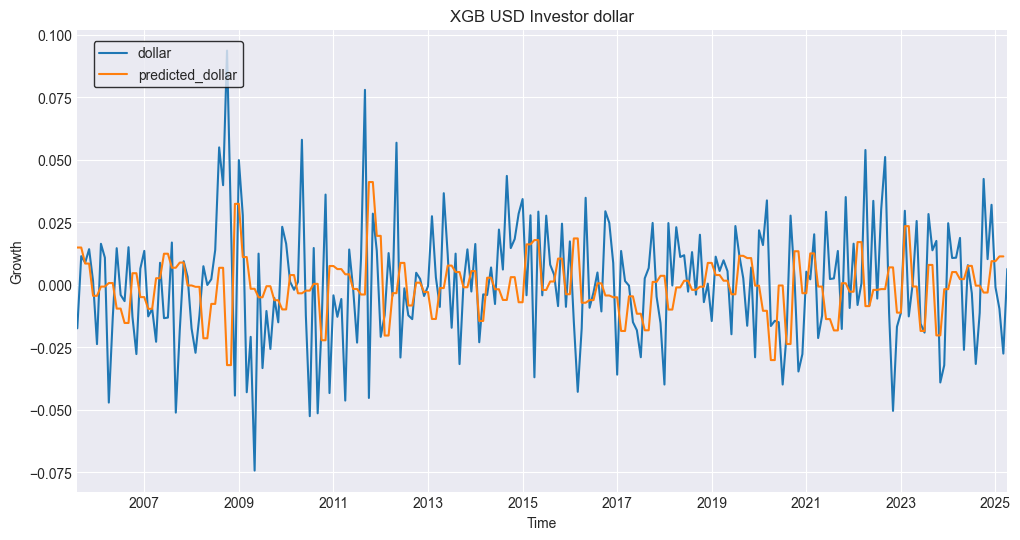

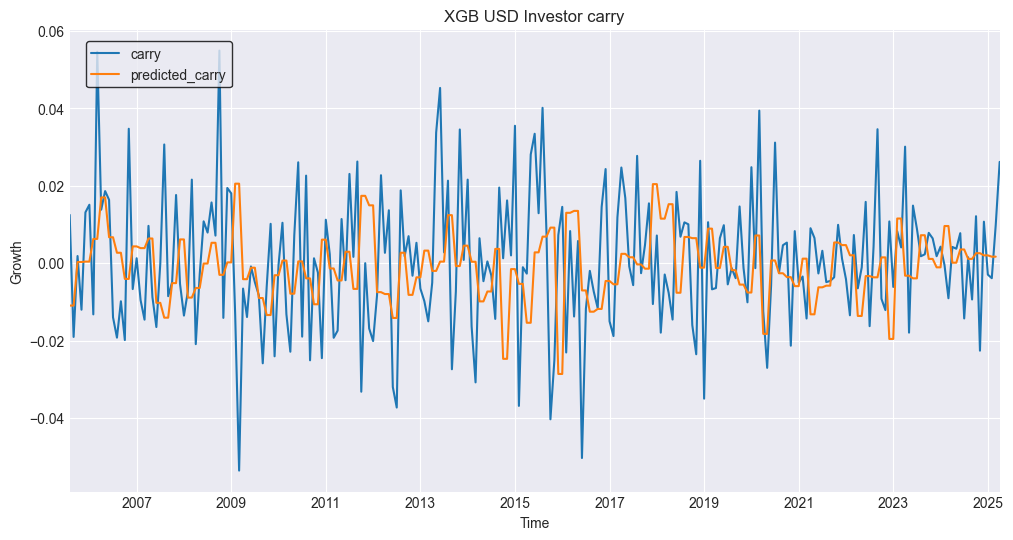

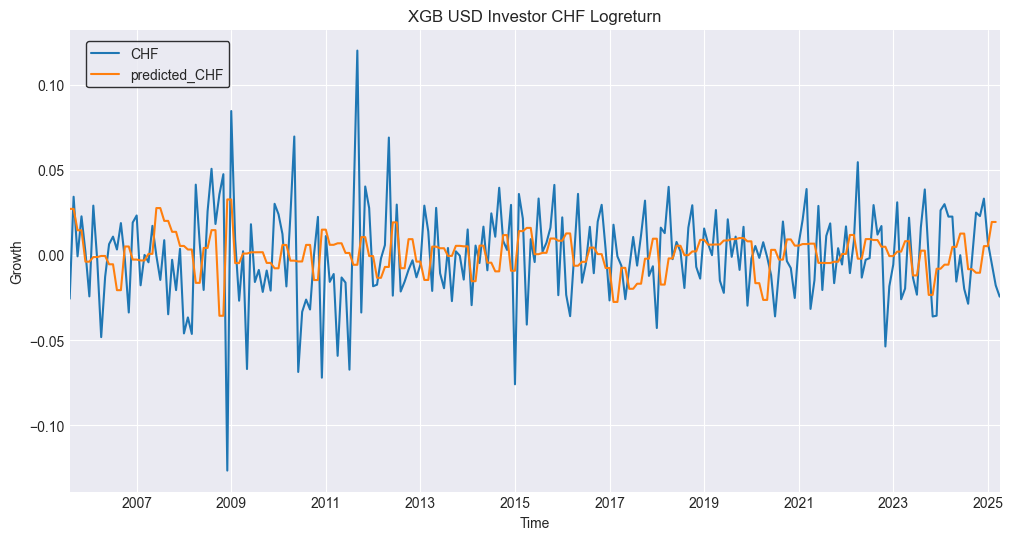

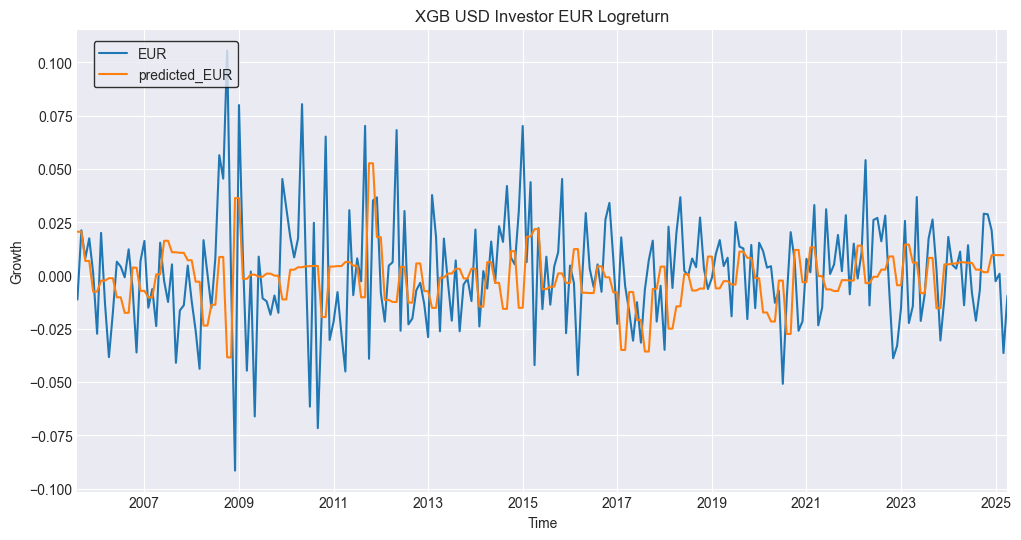

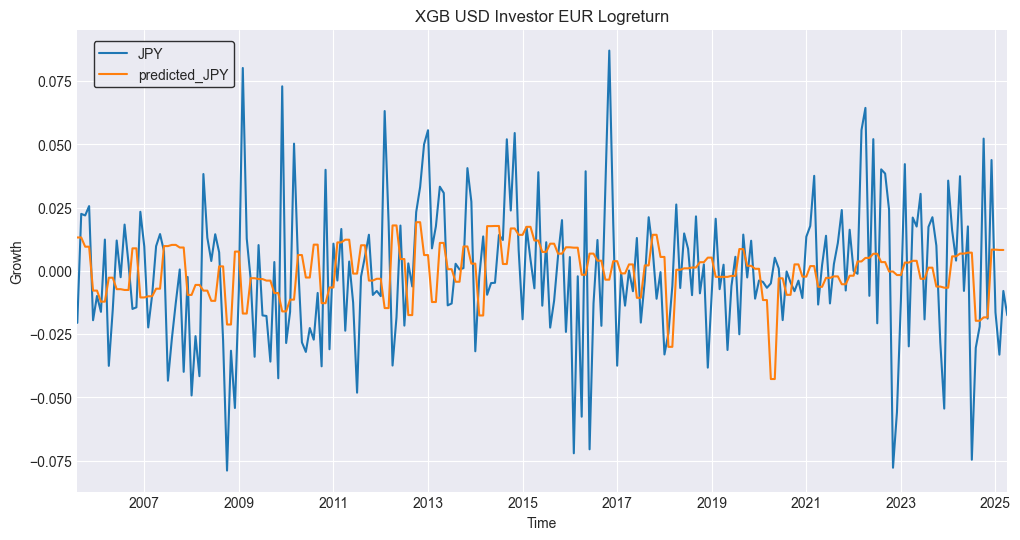

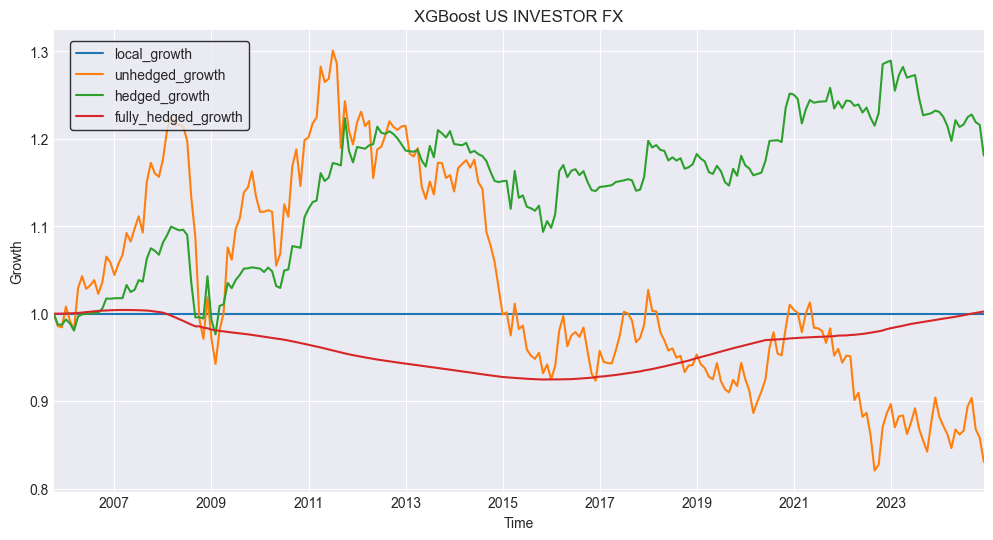

In [3]:

plot_simulation(factors[['dollar','predicted_dollar']],'XGB USD Investor dollar',save=True)
plot_simulation(factors[['carry','predicted_carry']],'XGB USD Investor carry',save=True)

plot_simulation(hedge_logreturns[['CHF','predicted_CHF']],'XGB USD Investor CHF Logreturn',save=True)
plot_simulation(hedge_logreturns[['EUR','predicted_EUR']],'XGB USD Investor EUR Logreturn',save=True)
plot_simulation(hedge_logreturns[['JPY','predicted_JPY']],'XGB USD Investor EUR Logreturn',save=True)

plot_simulation(df,'XGBoost US INVESTOR FX',save = True)




In [14]:
import statsmodels.api as sm


t = 1

factors = factorsUSD.iloc[t:t+60].copy()
fac = 'dollar'

# Zielvariable eine Periode voraus
#factors[fac] = factors[fac].shift(-1)

factors = factors.dropna()

# Zielvariable
y = factors[fac]

# Prädiktoren OHNE Intercept
pred = factors[['volatility','afd','ted','commodity']]

X = sm.add_constant(pred)

# OLS-Modell schätzen (kein add_constant!)
model = sm.OLS(y, X).fit()

# Zusammenfassung anzeigen
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 dollar   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     2.019
Date:                Mon, 26 May 2025   Prob (F-statistic):              0.104
Time:                        18:29:35   Log-Likelihood:                 150.01
No. Observations:                  60   AIC:                            -290.0
Df Residuals:                      55   BIC:                            -279.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.020      0.036      0.9

In [6]:
import statsmodels.api as sm
import pandas as pd

# Rolling OLS über multiple Fenster und p-Wert-Erfassung
def rolling_ols_avg_pvalues(factors, fac='carry', window=60):
    pvalues_list = []
    liste = []
    factors[fac] = factors[fac].shift(-1)
    for t in range(len(factors) - window + 1):
        window_df = factors.iloc[t:t+window].copy()

        # Zielvariable
        y = window_df[fac]

        # Prädiktoren
        pred = window_df[['volatility', 'afd', 'ted', 'commodity']]
        X = sm.add_constant(pred)

        # Modell schätzen
        model = sm.OLS(y, X).fit()

        # p-Werte speichern
        pvalues_list.append(model.pvalues)
        liste.append(model.rsquared)


    # Zu DataFrame
    pval_df = pd.DataFrame(pvalues_list)
    mean_pvals = pval_df.mean()


    return mean_pvals, pval_df, liste

# Anwendung auf dein DataFrame
# Beispiel: factorsUSD muss vorher existieren
mean_pvalues, all_pvalues, liste = rolling_ols_avg_pvalues(factors)

# Ausgabe
print("Durchschnittliche p-Werte über alle Fenster:")
print(mean_pvalues)

/var/folders/d1/tl_k5pld7wx2h0q26s602gnw0000gn/T/ipykernel_9148/2542038892.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factors[fac] = factors[fac].shift(-1)


Durchschnittliche p-Werte über alle Fenster:
const         0.512461
volatility    0.686278
afd           0.534119
ted           0.326481
commodity     0.618681
dtype: float64


In [7]:
x = liste[0:-2]
# carry
sum(x)/ len(x)

0.04685597295551324

In [32]:
x = liste[0:-9]

sum(x)/ len(x)

0.11186937242878721

In [77]:
df = pd.DataFrame()
df['hedge'] = df_hedge['SEK']
factors = factorsUSD

df = pd.concat([factors, df], axis=1)
df = df.dropna()
t = 3
df = df.iloc[t:t+60]


X = df[['carry','dollar']]
X = sm.add_constant(X)
y = df['hedge']


model = sm.OLS(y, X).fit()

# Zusammenfassung anzeigen
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  hedge   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     163.2
Date:                Mon, 26 May 2025   Prob (F-statistic):           2.55e-24
Time:                        17:27:14   Log-Likelihood:                 181.72
No. Observations:                  60   AIC:                            -357.4
Df Residuals:                      57   BIC:                            -351.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.002      0.641      0.5

In [1]:
from database.insert import *
from database.models import *
from database.functions import *
from database.session import session
from simulation.functions import *
import pandas as pd
import numpy as np


base = 'USD'
portfolio_name = 'portfolio' + base



title = 'Inestor CHF FX'
data = get_portfolio_data(portfolio_name,base)


asset_logreturns = data[0]
currency_list = data[1]
fx_logreturns = data[2]
fwd_logreturns = data[3]
weights = data[4]
df_hedge = data[5]
factors = data[6]

factors['carry'] = factors['carry'].shift(-1)
factors['dollar'] = factors['dollar'].shift(-1)

factors = factors.dropna()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/fabianblaser/PycharmProjects/Bachelor/simulation/functions/get_portfolio_data.py:29: SAWarning: relationship 'CPI_REF.indicator' will copy column CPI_REF.series_id to column ECONOMIC_INDICATOR.series_id, which conflicts with relationship(s): 'GDP_REF.indicator' (copies GDP_REF.series_id to ECONOMIC_INDICATOR.series_id). If this is not the intention, consider if these relationships should be linked with back_populates, or if viewonly=True should be applied to one or more if they are read-only. For the less common case that foreign key constraints are partially overlapping, the orm.foreign() annotation can be used to isolate the columns that should be written towards.   To silence this warning, add th

In [92]:
df  = pd.read_csv('database/csv_file/ted.csv')
df['date'] = pd.to_datetime(df['date'],dayfirst=True)
df.set_index('date', inplace=True)

<AxesSubplot: xlabel='date'>

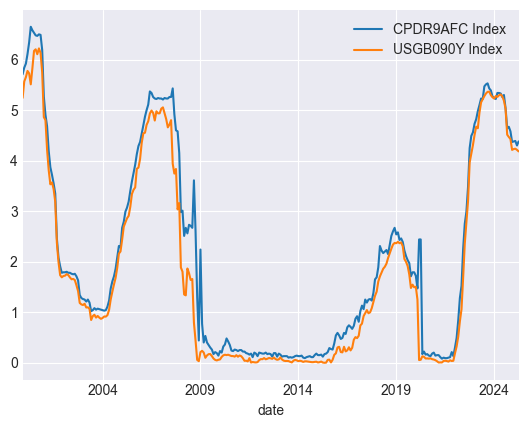

In [93]:
df[['CPDR9AFC Index', 'USGB090Y Index']].plot()


In [1]:

from simulation.functions import *
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt

base = 'USD'
portfolio_name = 'portfolio' + base


data = get_portfolio_data(portfolio_name,base)


asset_logreturns = data[0]
currency_list = data[1]
fx_logreturns = data[2]
fwd_logreturns = data[3]
weights = data[4]
df_hedge = data[5]
factors = data[6]

dict_params = {
            'n_estimators': 100,
            'max_depth': 2,
            'learning_rate': 0.05,
            'n_jobs': -1
            }


dollar = factors['dollar']
carry = factors['carry']
predictors = factors.drop(columns = ['carry','dollar'])

model_dollar = XGBRegressor(**dict_params)
model_carry = XGBRegressor(**dict_params)

model_dollar.fit(predictors,dollar)
model_carry.fit(predictors,carry)

print(factors )



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/fabianblaser/PycharmProjects/Bachelor/simulation/functions/get_portfolio_data.py:29: SAWarning: relationship 'CPI_REF.indicator' will copy column CPI_REF.series_id to column ECONOMIC_INDICATOR.series_id, which conflicts with relationship(s): 'GDP_REF.indicator' (copies GDP_REF.series_id to ECONOMIC_INDICATOR.series_id). If this is not the intention, consider if these relationships should be linked with back_populates, or if viewonly=True should be applied to one or more if they are read-only. For the less common case that foreign key constraints are partially overlapping, the orm.foreign() annotation can be used to isolate the columns that should be written towards.   To silence this warning, add th

              dollar     carry  volatility       ted  commodity       afd
date                                                                     
2000-08-31  0.021078 -0.016210   -0.092208 -0.472082  -0.021111 -0.000310
2000-09-30  0.015915  0.013955    0.083640 -0.241104  -0.001455 -0.000260
2000-10-31  0.029277 -0.021029    0.121496 -0.082911   0.004224 -0.000274
2000-11-30 -0.009252  0.013728   -0.014672  0.085984   0.008298 -0.000366
2000-12-31 -0.043700  0.050794   -0.082239  0.065550   0.000060 -0.000253
...              ...       ...         ...       ...        ...       ...
2024-12-31  0.032047  0.010704   -0.040643  0.074280  -0.002334 -0.000418
2025-01-31 -0.000895 -0.002955    0.062349 -0.097779   0.004658 -0.000482
2025-02-28 -0.009551 -0.003884   -0.172238  0.003393   0.002158 -0.000620
2025-03-31 -0.027505  0.009836    0.085841 -0.197706   0.006528 -0.000679
2025-04-30  0.006394  0.026144    0.757845  0.089711   0.003451 -0.000683

[293 rows x 6 columns]


In [64]:

import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Nehme an, du hast bereits diese Daten vorbereitet:
# predictors: DataFrame mit Spalten ['ted', 'volatility', 'afd', 'commodity']
# carry: Zielvariable (Pandas Series)

# Kombiniere alles in ein DataFrame
df = predictors.copy()
df['carry'] = carry

# Baue das lineare Regressionsmodell
model = smf.ols('carry ~ ted + volatility + afd + commodity', data=df).fit()

# Zusammenfassung mit R², p-Werten etc.
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  carry   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     3.546
Date:                Mon, 26 May 2025   Prob (F-statistic):            0.00764
Time:                        10:04:20   Log-Likelihood:                 772.93
No. Observations:                 293   AIC:                            -1536.
Df Residuals:                     288   BIC:                            -1517.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0005      0.001      0.417      0.6

In [8]:
from xgboost import XGBRegressor
import statsmodels.formula.api as smf
# 1. Trainiere XGBoost auf carry
model_xgb = XGBRegressor()
model_xgb.fit(predictors, carry)

# 2. Vorhersage aus XGBoost
df = predictors.copy()
df['carry_xgb'] = model_xgb.predict(predictors)

# 3. Regressiere die XGBoost-Predictions mit OLS auf dieselben Inputs
model_explain = smf.ols('carry_xgb ~ ted + volatility + afd + commodity', data=df).fit()

# 4. Ergebnisse anzeigen
print(model_explain.summary())

                            OLS Regression Results                            
Dep. Variable:              carry_xgb   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     3.873
Date:                Mon, 26 May 2025   Prob (F-statistic):            0.00442
Time:                        13:39:27   Log-Likelihood:                 786.17
No. Observations:                 293   AIC:                            -1562.
Df Residuals:                     288   BIC:                            -1544.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0005      0.001      0.436      0.6

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/fabianblaser/PycharmProjects/Bachelor/simulation/functions/get_portfolio_data.py:29: SAWarning: relationship 'CPI_REF.indicator' will copy column CPI_REF.series_id to column ECONOMIC_INDICATOR.series_id, which conflicts with relationship(s): 'GDP_REF.indicator' (copies GDP_REF.series_id to ECONOMIC_INDICATOR.series_id). If this is not the intention, consider if these relationships should be linked with back_populates, or if viewonly=True should be applied to one or more if they are read-only. For the less common case that foreign key constraints are partially overlapping, the orm.foreign() annotation can be used to isolate the columns that should be written towards.   To silence this warning, add th

AUD — hit ratio: 41.38%
CAD — hit ratio: 46.98%
EUR — hit ratio: 54.31%
JPY — hit ratio: 54.74%
NZD — hit ratio: 46.12%
NOK — hit ratio: 53.88%
CHF — hit ratio: 54.31%
GBP — hit ratio: 54.78%
USD — hit ratio: 54.31%


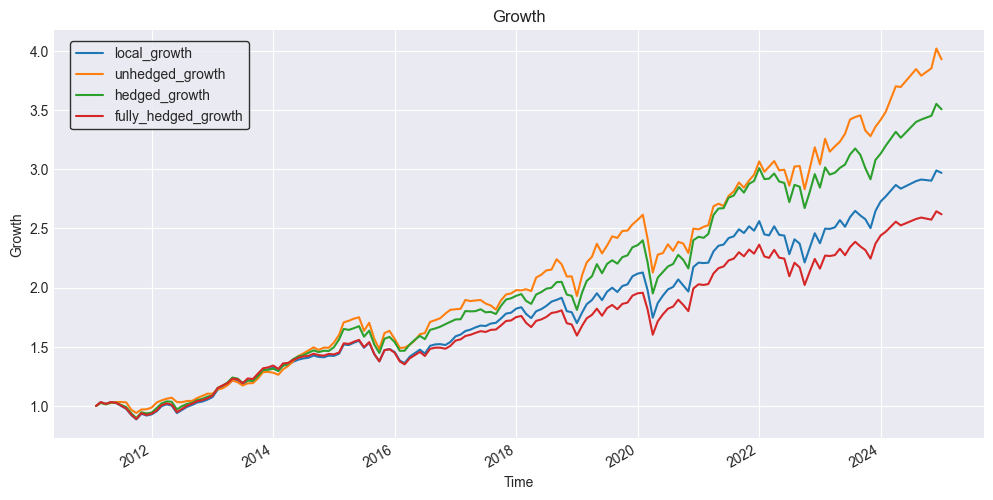

In [1]:
from database.insert import *
from database.models import *
from database.functions import *
from database.session import session
from simulation.functions import *
import pandas as pd
import numpy as np


base = 'SEK'
portfolio_name = 'portfolio' + base


data = get_portfolio_data(portfolio_name,base)


asset_logreturns = data[0]
currency_list = data[1]
fx_logreturns = data[2]
fwd_logreturns = data[3]
weights = data[4]
df_hedge = data[5]
factors = data[6]

predict = xgboost(currency_list,
                  df_hedge,
                  factors,
                  duration =2)

hedge_ratios = predict[0]

df = simulate_portfolio(asset_logreturns,
                        currency_list,
                        fx_logreturns,
                        fwd_logreturns,
                        weights,
                        hedge_ratios,
                        start = '2011-01-01',
                        end = '2024-12-31',
                        fx_portfolio = False)

plot_simulation(df)


In [3]:
print(predict[1])
df_hedge

                 AUD       CAD       EUR       JPY       NZD       NOK  \
date                                                                     
2005-08-31 -0.006282 -0.004833 -0.004552 -0.007378 -0.004143 -0.000522   
2005-09-30  0.016592  0.003438  0.005904  0.019010  0.006217 -0.005132   
2005-10-31 -0.019436 -0.001800 -0.009680 -0.026793 -0.000520 -0.028888   
2005-11-30  0.006752 -0.008589  0.000316 -0.005538  0.032121 -0.013706   
2005-12-31  0.003365 -0.012549 -0.007620  0.001713  0.003451  0.005768   
...              ...       ...       ...       ...       ...       ...   
2024-12-31 -0.006723 -0.007502 -0.003836  0.006299 -0.012626 -0.024599   
2025-01-31 -0.013022 -0.001523  0.015068  0.009407 -0.029649 -0.004223   
2025-02-28 -0.015156 -0.000457  0.014017 -0.000044 -0.024734 -0.005644   
2025-03-31 -0.015156 -0.002340  0.014017  0.019201 -0.035396 -0.008064   
2025-04-30       NaN       NaN       NaN       NaN       NaN       NaN   

                 CHF       GBP       

,JPY,NOK,USD,CAD,CHF,EUR,GBP,NZD,AUD
date,,,,,,,,,
1999-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-31,0.012915,-0.002402,-0.030957,-0.030334,0.013529,-0.004418,NaN,0.022579,-0.003473
2000-02-29,0.022636,0.015719,0.001225,0.003993,0.009048,0.019406,NaN,0.018370,0.036530
2000-03-31,-0.061980,0.019037,0.012863,0.013757,0.016284,0.021107,NaN,-0.008108,0.029714
2000-04-30,0.008089,0.021240,-0.037457,-0.014961,-0.003474,0.013393,NaN,-0.015255,-0.007554
...,...,...,...,...,...,...,...,...,...
2024-12-31,0.029996,0.013295,-0.013801,0.014200,0.019413,0.007373,0.004011,0.042814,0.037505
2025-01-31,-0.018956,-0.007300,-0.002559,0.008585,0.005058,-0.005241,0.006854,-0.009933,-0.006385
2025-02-28,-0.005091,0.022621,0.028049,0.024957,0.022811,0.028890,0.013102,0.034836,0.028692


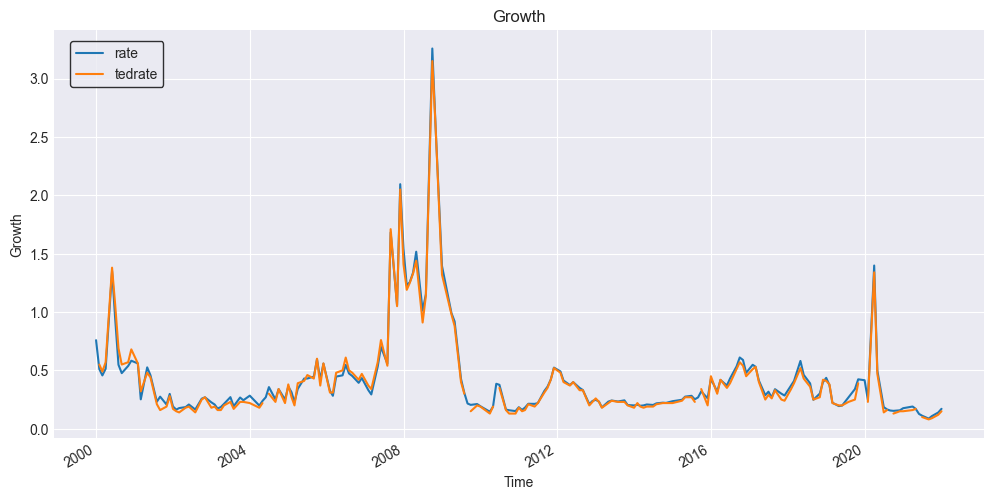

In [2]:
tedrate = pd.read_csv('database/csv_file/TEDRATE.csv')
tedrate.columns = ['date','tedrate']
tedrate['date'] = pd.to_datetime(tedrate['date'],dayfirst=False)
tedrate.set_index('date', inplace=True)

ted = create_ted_factor()

combi = pd.concat([ted ,tedrate],axis = 1,join = 'inner')

plot_simulation(combi)

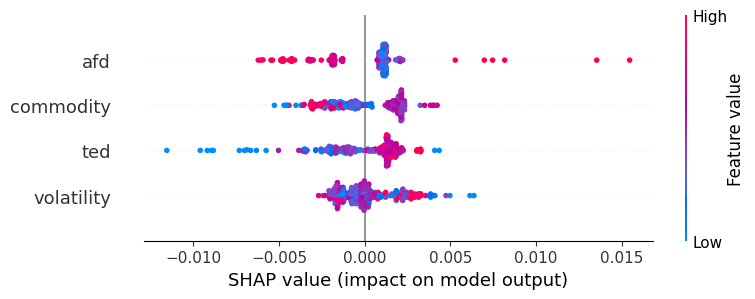

In [18]:
from xgboost import XGBRegressor
import shap

# Daten vorbereiten
factors = factors.dropna()
fac = factors['carry']
predictors = factors[['ted', 'volatility', 'afd', 'commodity']]

# Modell trainieren
model = XGBRegressor(
    n_estimators=100,
    max_depth=2,
    learning_rate=0.05
)
model.fit(predictors, fac)

# SHAP-Analyse
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(predictors)

# Plot
shap.summary_plot(shap_values, predictors)

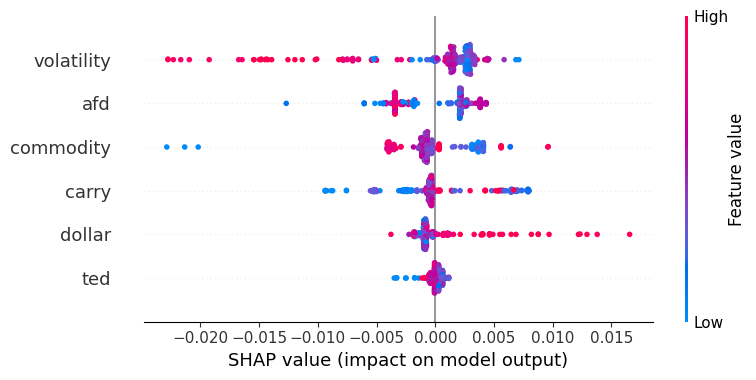

In [28]:
from xgboost import XGBRegressor
import shap
h = df_hedge['JPY']
h = pd.DataFrame(h)
h.columns = ['hedge']
# Daten vorbereiten
factors = factors.dropna()

new = pd.concat([factors, h], axis = 1,join = 'inner')

fac = new['hedge']
predictors = new[['carry','dollar','ted', 'volatility', 'afd', 'commodity']]



# Modell trainieren
model = XGBRegressor(
    n_estimators=100,
    max_depth=2,
    learning_rate=0.05
)
model.fit(predictors, fac)

# SHAP-Analyse
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(predictors)

# Plot
shap.summary_plot(shap_values, predictors)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


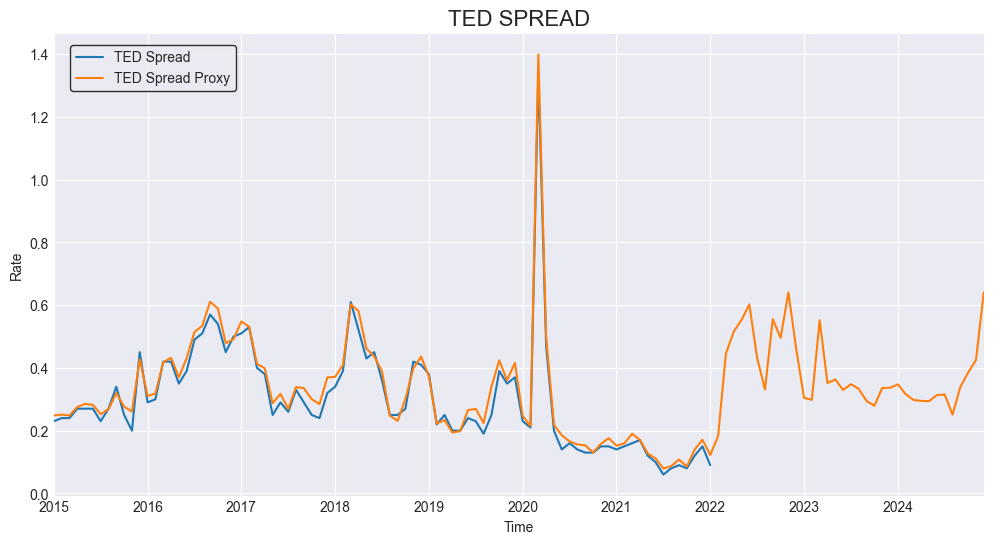

In [1]:
from database.functions import *
from simulation.functions import *
import pandas as pd
ted = pd.read_csv('database/csv_file/TEDRATE.csv')
ted_new = create_ted_factor()
ted.columns = ['date','TED Spread old']
ted['date'] = pd.to_datetime(ted['date'],dayfirst=False)
ted.set_index('date', inplace=True)
ted = ted.resample('M').last()

df = pd.concat([ted ,ted_new],axis = 1)
df.columns = ['TED Spread','TED Spread Proxy']

start = '2015-01-01'
end = '2024-12-31'
start = pd.to_datetime(start,dayfirst=False)
end = pd.to_datetime(end,dayfirst=False)

df = df[start:end]

plot_simulation(df,save = True,title = 'TED SPREAD',ylabel = 'Rate')

In [3]:
file = pd.read_csv('database/csv_file/file.csv',sep = ';')
file

,date,CRB CMDT Index,US0003M Index,SOFR90A Index,CPDR9AFC Index,USGB090Y Index
0,31.12.1999,NaN,6.00125,NaN,5.71,5.24252
1,31.01.2000,225.03,6.07750,NaN,5.84,5.56682
2,29.02.2000,220.68,6.10875,NaN,5.92,5.65182
3,31.03.2000,228.01,6.29000,NaN,6.11,5.77603
4,28.04.2000,227.37,6.50250,NaN,6.34,5.72785
...,...,...,...,...,...,...
300,31.12.2024,536.50,4.85372,4.69157,4.37,4.21316
301,31.01.2025,541.96,4.85372,4.51270,4.38,4.22969
302,28.02.2025,539.22,4.85372,4.42184,4.39,4.23696
303,31.03.2025,547.11,4.85372,4.35445,4.30,4.21333
